## Import Package

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.8.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

## Work directory

In [ ]:
import zipfile
with zipfile.ZipFile('cassava-leaf-disease-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('')

WORK_DIR = 'dataset'
os.listdir(WORK_DIR)

['basic_EfNetB0_imagenet_512.h5',
 'EffNetB0_512_8.h5',
 '.ipynb_checkpoints',
 'train.csv',
 'test_tfrecords',
 'train_images',
 'label_num_to_disease_map.json',
 'test_images',
 'train_tfrecords',
 'sample_submission.csv']

# Tampilan awal data

In [ ]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [ ]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [ ]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [ ]:
print(train_labels['label'].value_counts())

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


## Sample label "0" : "Cassava Bacterial Blight (CBB)"

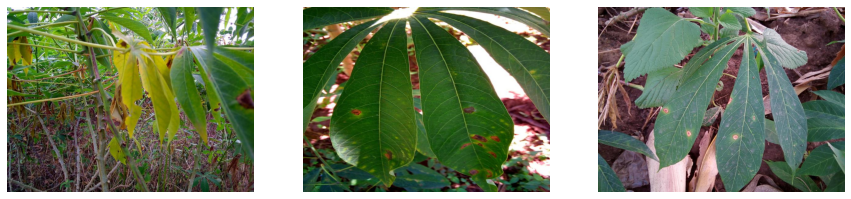

In [ ]:
sample = train_labels[train_labels.label == 0].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")

plt.show()

## Sample label "1" : "Cassava Brown Streak Disease (CBSD)"

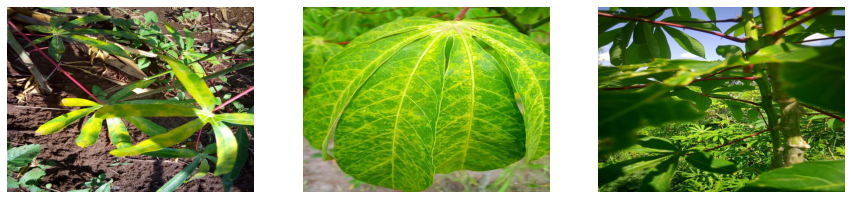

In [ ]:
sample = train_labels[train_labels.label == 1].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")

plt.show()

## Sample label "2" : "Cassava Green Mottle (CGM)"

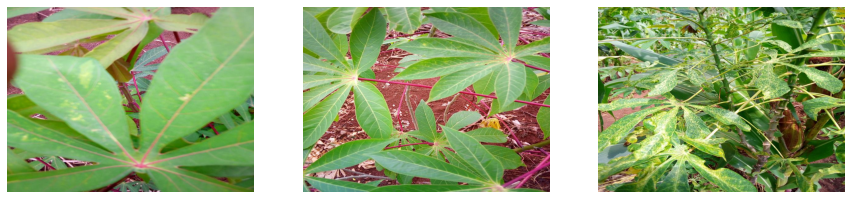

In [ ]:
sample = train_labels[train_labels.label == 2].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")

plt.show()

## Sample label "3" : "Cassava Mosaic Disease (CMD)"

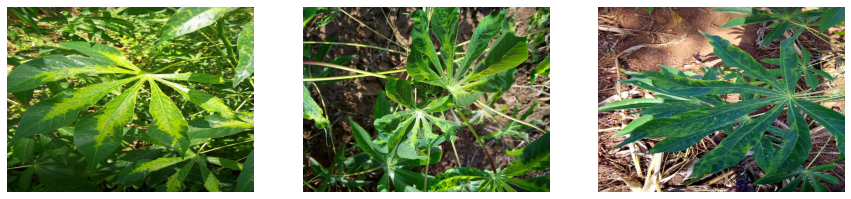

In [ ]:
sample = train_labels[train_labels.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")

plt.show()

## Sample label "4" : "Healthy"

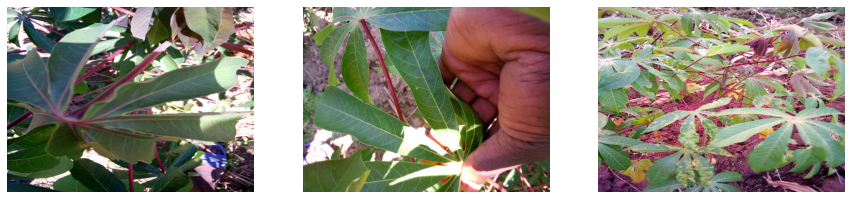

In [ ]:
sample = train_labels[train_labels.label == 4].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")

plt.show()

# Persiapan model

In [ ]:
# Main parameters
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 512

### ImageDataGenerator

In [ ]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 30,  # Mengurangi augmentasi
                                     zoom_range = 0.1,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.05,
                                     height_shift_range = 0.05,
                                     width_shift_range = 0.05)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


### Sembarang sampel gambar sebelum augmentasi

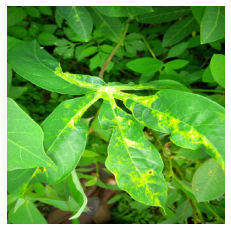

In [ ]:
img_path = os.path.join(WORK_DIR, "train_images", train_labels.image_id[20])
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

### Gambar setelah augmentasi

Found 1 validated image filenames belonging to 1 classes.


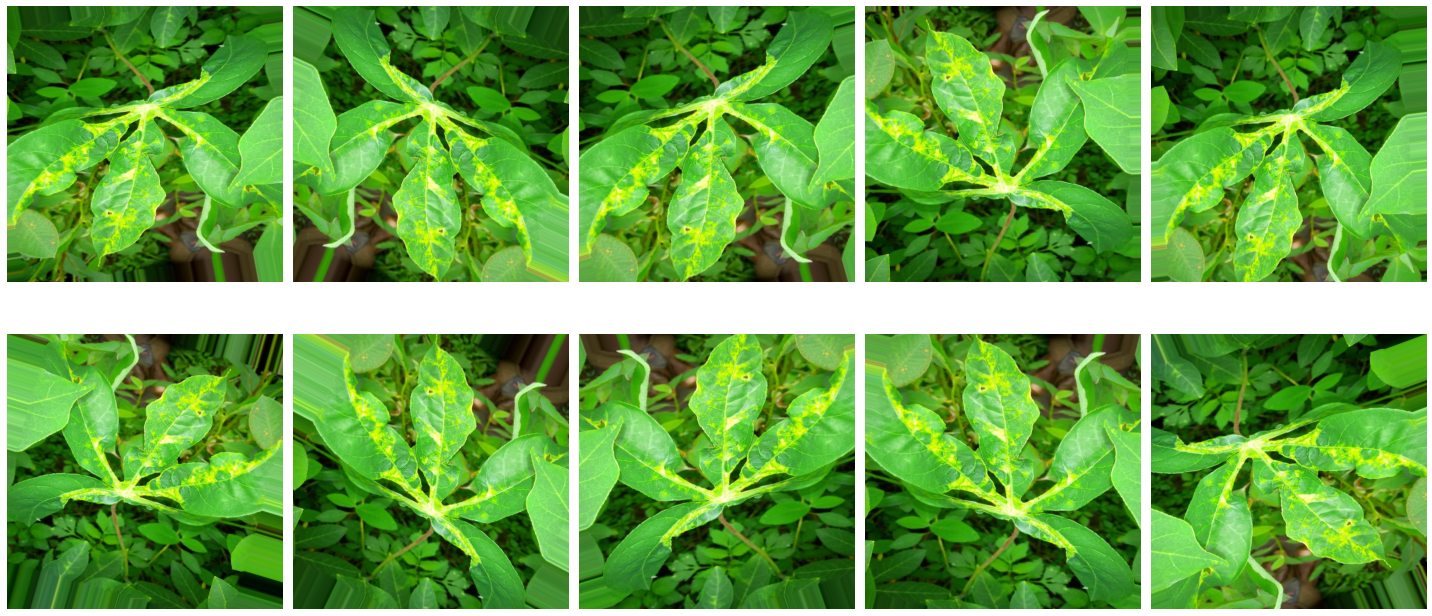

In [ ]:
generator = train_datagen.flow_from_dataframe(train_labels.iloc[20:21],
                         directory = os.path.join(WORK_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Modeling

In [ ]:
# Code for basic EfficientNetB0 CNN
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
model = create_model()
model.summary()

2024-08-30 07:05:20.317231: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 07:05:22.928526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78558 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 513, 513, 3)  0           ['normalization[0][0]']      

In [ ]:
model.save('dataset/basic_EfNetB0_imagenet_512.h5')

In [ ]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 239 layers


### Load bobot

In [ ]:
model.load_weights('dataset/basic_EfNetB0_imagenet_512.h5')


### Pelatihan

In [ ]:
model_save = ModelCheckpoint('./EffNetB0_512_8_best_weights.h5',
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20


2024-08-30 07:05:44.935012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2024-08-30 07:05:49.466730: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-30 07:05:49.468450: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-30 07:05:49.468481: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-08-30 07:05:49.469435: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-30 07:05:49.469509: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-08-30 07:05:49.979946: I tensorflow/stream_executor/cuda/c

2140/2139 [==============================] - ETA: 0s - loss: 0.6451 - acc: 0.7739
Epoch 1: val_loss improved from inf to 0.52671, saving model to ./EffNetB0_512_8_best_weights.h5
2139/2139 [==============================] - 1111s 508ms/step - loss: 0.6451 - acc: 0.7739 - val_loss: 0.5267 - val_acc: 0.8222 - lr: 0.0010
Epoch 2/20
2140/2139 [==============================] - ETA: 0s - loss: 0.5163 - acc: 0.8221
Epoch 2: val_loss improved from 0.52671 to 0.51591, saving model to ./EffNetB0_512_8_best_weights.h5
2139/2139 [==============================] - 1084s 506ms/step - loss: 0.5163 - acc: 0.8221 - val_loss: 0.5159 - val_acc: 0.8205 - lr: 0.0010
Epoch 3/20
2140/2139 [==============================] - ETA: 0s - loss: 0.4806 - acc: 0.8384
Epoch 3: val_loss improved from 0.51591 to 0.45007, saving model to ./EffNetB0_512_8_best_weights.h5
2139/2139 [==============================] - 1083s 506ms/step - loss: 0.4806 - acc: 0.8384 - val_loss: 0.4501 - val_acc: 0.8439 - lr: 0.0010
Epoch 4/20

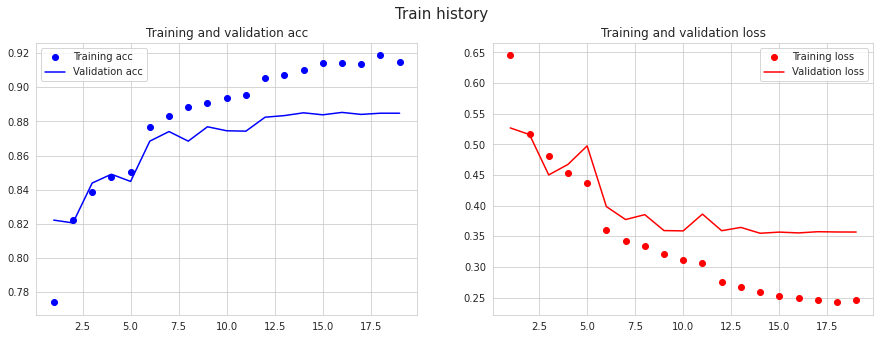

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
model.save('dataset/EffNetB0_512_8.h5')

## Hasil pelatihan dan metrik evaluasi

In [ ]:
y_true = []
y_pred = []

# Iterasi melalui generator untuk mengumpulkan semua prediksi dan label sebenarnya
for i in range(len(validation_generator)):
    X_batch, y_batch = validation_generator[i]
    y_true.extend(y_batch)
    y_pred_batch = model.predict(X_batch)
    y_pred.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8850
Precision: 0.8873
Recall: 0.8850
F1 Score: 0.8857
Confusion Matrix:
[[ 134   14    1   10   41]
 [  27  341    9   15   44]
 [  11   11  394   38   41]
 [   6   10   35 2550   37]
 [  53   25   20   44  368]]


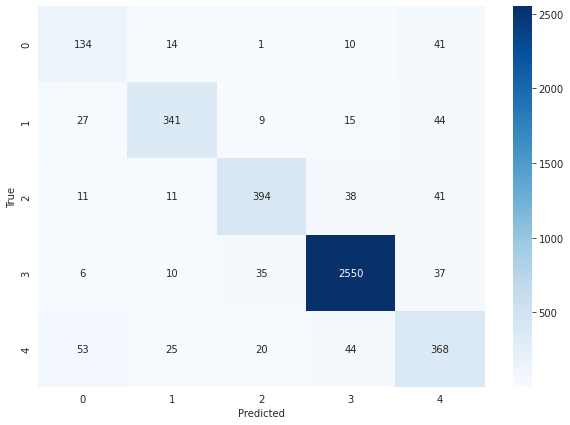

In [ ]:
# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
y_true = []
y_pred = []

# Iterasi melalui generator untuk mengumpulkan semua prediksi dan label sebenarnya
for i in range(len(train_generator)):
    X_batch, y_batch = train_generator[i]
    y_true.extend(y_batch)
    y_pred_batch = model.predict(X_batch)
    y_pred.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.9234
Precision: 0.9229
Recall: 0.9234
F1 Score: 0.9230
Confusion Matrix:
[[  695    39    14    28   111]
 [   59  1517    32    50    95]
 [   17    26  1622   153    73]
 [   20    32   118 10295    55]
 [  130    78    74   108  1677]]


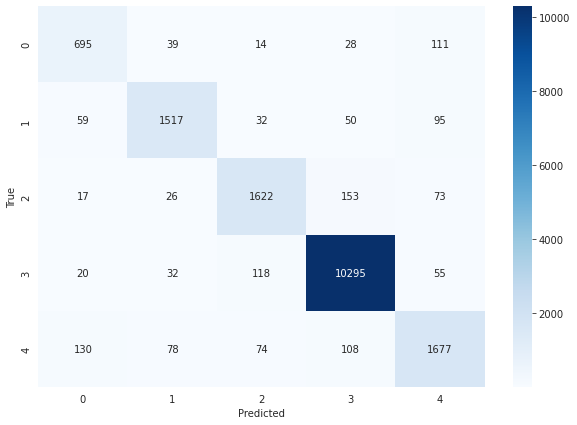

In [ ]:
# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualisasi aktivas CNN

In [ ]:
def activation_layer_vis(img, activation_layer = 0, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)

    rows = int(activations[activation_layer].shape[3] / 3)
    cols = int(activations[activation_layer].shape[3] / rows)
    fig, axes = plt.subplots(rows, cols, figsize = (15, 15 * cols))
    axes = axes.flatten()

    for i, ax in zip(range(activations[activation_layer].shape[3]), axes):
        ax.matshow(activations[activation_layer][0, :, :, i], cmap = 'viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Visualisasi lapisan ke - 1

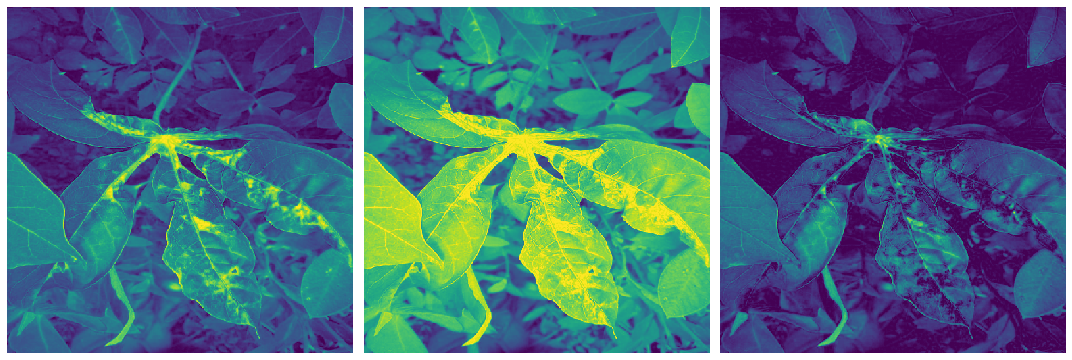

In [ ]:
activation_layer_vis(img_tensor, 0)

In [ ]:
def all_activations_vis(img, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)

    layer_names = []
    for layer in model.layers[:layers]:
        layer_names.append(layer.name)

    images_per_row = 3
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * 5 * display_grid.shape[1],
                            scale * 5 * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

### Visualisasi lapisan ke - 5

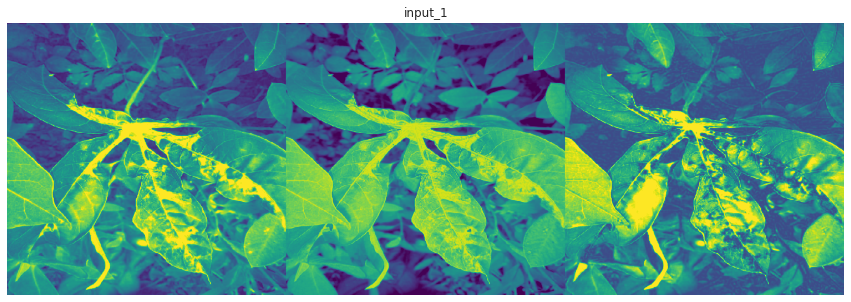

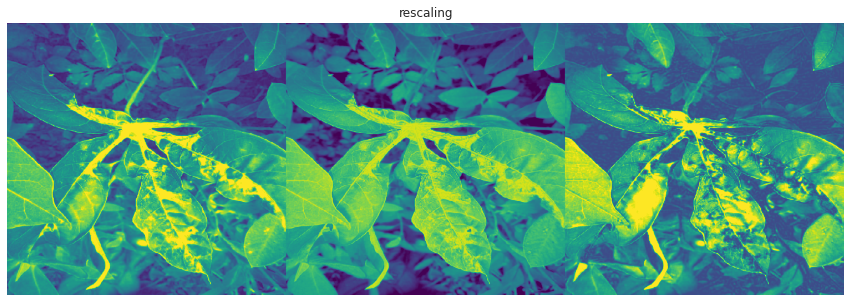

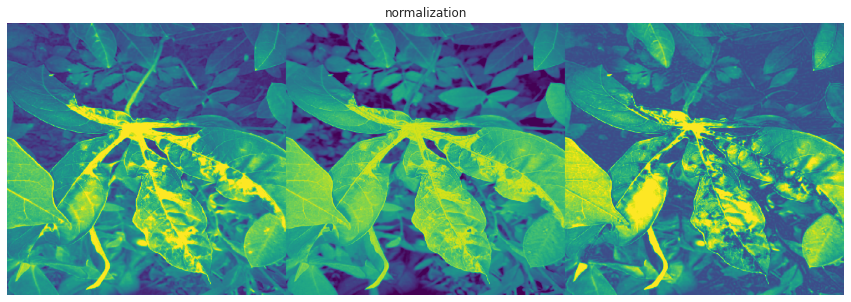

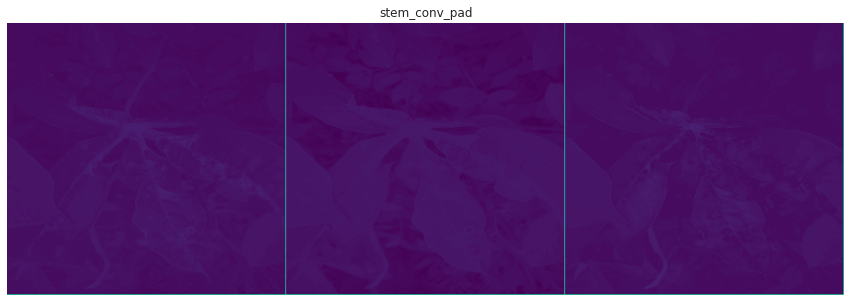

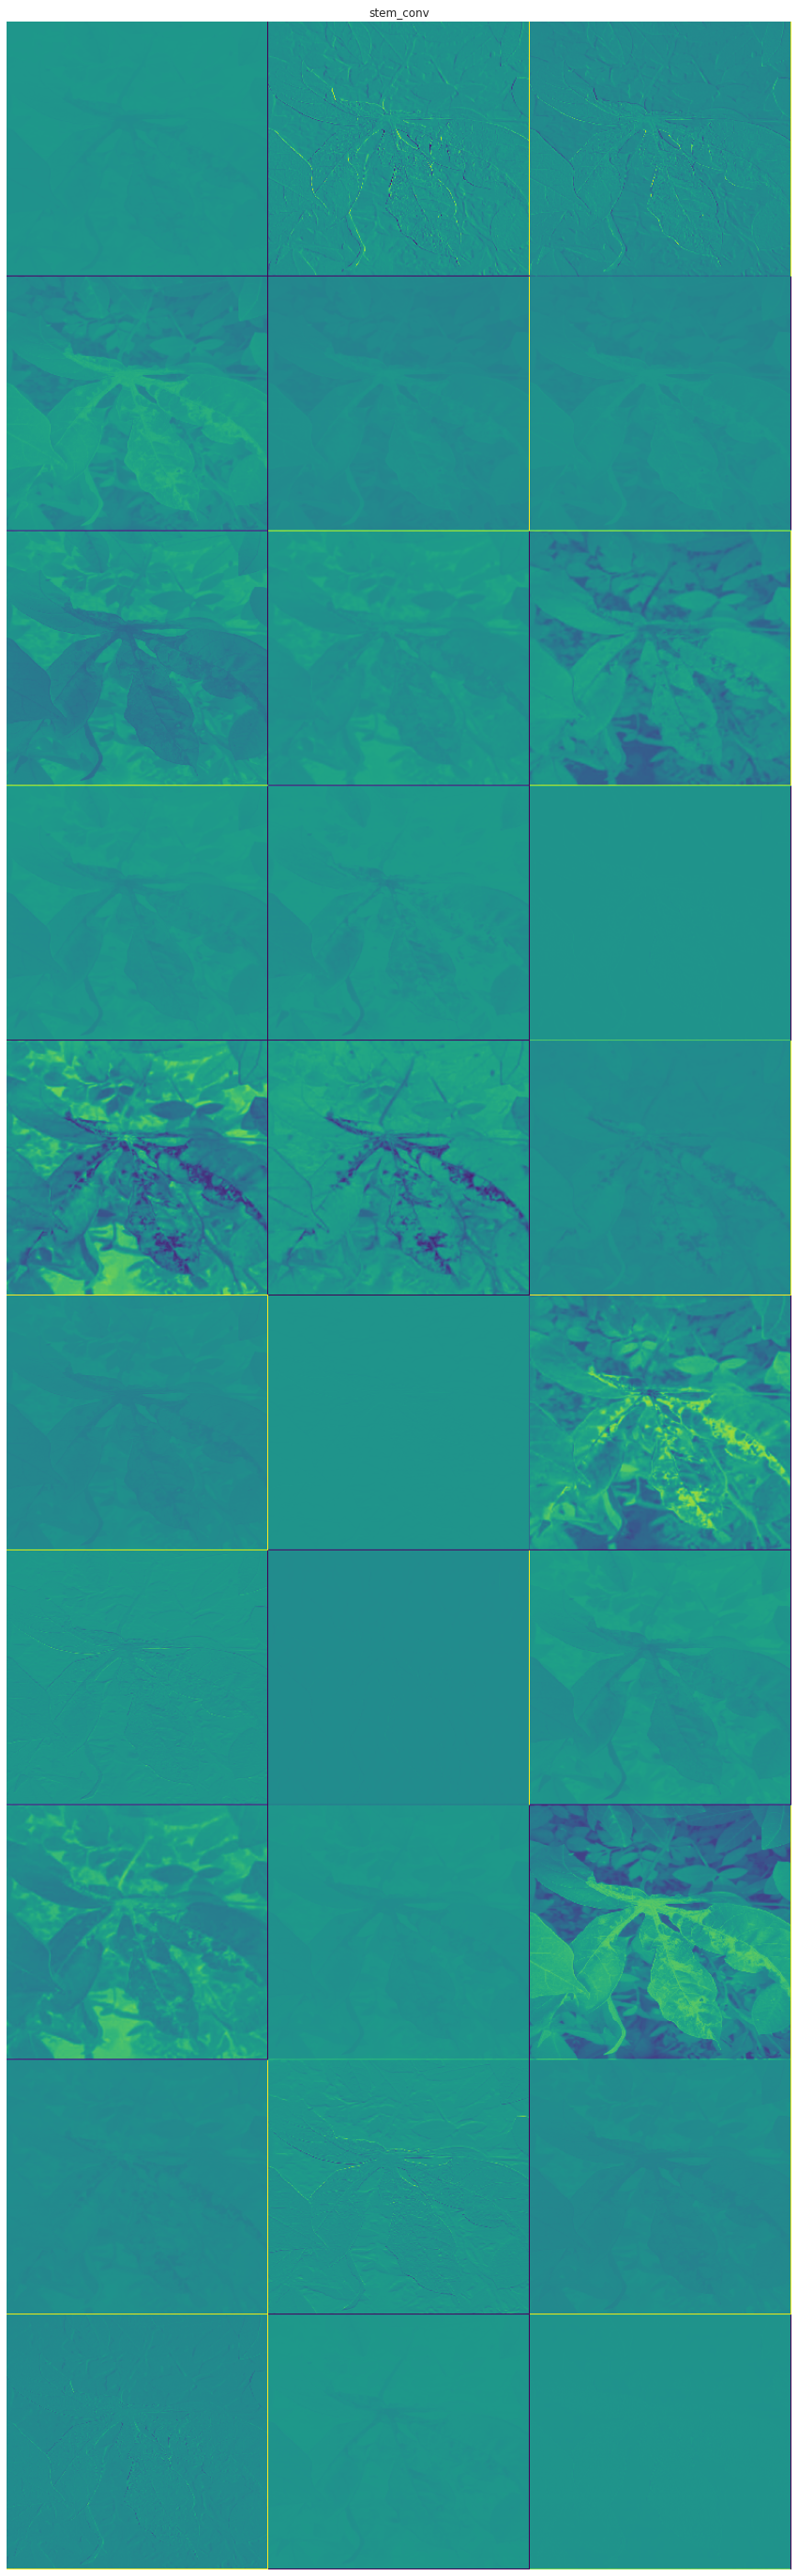

In [ ]:
all_activations_vis(img_tensor, 5)